***Лабораторная работа 4*** Синтаксически управляемый переход

In [184]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'

from graphviz import Digraph
from typing import Type, List, Tuple

position = 0
print_eps_nodes = False

In [185]:
class Node:
    def __init__(self, value):
        self.value = value
        self.children = []
        self.res = []

    def _is_empty_node(self):
        if len(self.children) == 1 and self.children[0].value == 'ε':
            return True
        return False

    def print(self, tree=None, parent_value="", id="main"):
        if not tree:
            tree = Digraph()
            tree.node_attr["shape"] = "plain"

        if not print_eps_nodes and self._is_empty_node():
            return tree

        if self.value == '<>':
            tree.node(id, str('\<\>') + '\n' + " ".join(self.res))
        else:
            tree.node(id, str(self.value) + '\n' + " ".join(self.res))
        if parent_value:
            tree.edge(parent_value, id)

        for i, child in enumerate(self.children):
            child.print(tree, id, id + "." + str(i))

        return tree
    
def parse_lex(tree: Node, lexemes: List[str], lex: str) -> bool:
    global position
    if position >= len(lexemes):
        return False

    if lexemes[position] == lex:
        tree.children.append(Node(lex))
        position += 1
        return True

    return False

**Парсинг Грамматики**

In [186]:
def parse_operation_type_multiplication(tree: Node, lexemes: List[str]) -> bool:
    global position
    if position >= len(lexemes):
        return False

    if lexemes[position] in ['*', '/']:
        new_node = Node("\<операция типа умножения\>")
        new_node.children.append(Node(lexemes[position]))
        new_node.res = [lexemes[position]]
        tree.children.append(new_node)
        position += 1
        return True
    return False

def parse_operation_type_addition(tree: Node, lexemes: List[str]) -> bool:
    global position
    if position >= len(lexemes):
        return False

    if lexemes[position] in ['+', '-']:
        new_node = Node("\<операция типа сложения\>")
        new_node.children.append(Node(lexemes[position]))
        new_node.res = [lexemes[position]]
        tree.children.append(new_node)
        position += 1
        return True
    return False

def parse_operation_relation(tree: Node, lexemes: List[str]) -> bool:
    global position
    if position >= len(lexemes):
        return False

    if lexemes[position] in ['<', '<=', '=', '<>', '>', '>=']:
        new_node = Node("\<операция отношения\>")
        new_node.children.append(Node(lexemes[position]))
        new_node.res = [lexemes[position]]
        tree.children.append(new_node)
        position += 1
        return True
    return False

def parse_identifier(tree: Node, lexemes: List[str]) -> bool:
    global position
    if position >= len(lexemes):
        return False

    if lexemes[position].isalpha() and lexemes[position] not in ['begin', 'end']:
        new_node = Node("\<идентификатор\>")
        new_node.children.append(Node(lexemes[position]))
        new_node.res = [lexemes[position]]
        tree.children.append(new_node)
        position += 1
        return True
    return False

def parse_const(tree: Node, lexemes: List[str]) -> bool:
    global position
    if position >= len(lexemes):
        return False

    try:
        value = int(lexemes[position])
    except:
        try:
            value = float(lexemes[position])
        except:
            return False

    new_node = Node("\<константа\>")
    new_node.children.append(Node(value))
    new_node.res = [lexemes[position]]
    tree.children.append(new_node)
    position += 1
    return True

def parse_factor(tree: Node, lexemes: List[str]) -> bool:
    new_node = Node("\<фактор\>")
    if parse_identifier(new_node, lexemes):
        new_node.res = new_node.children[0].res
        tree.children.append(new_node)
        return True
    elif parse_const(new_node, lexemes):
        new_node.res = new_node.children[0].res
        tree.children.append(new_node)
        return True
    elif parse_lex(new_node, lexemes, '('):
        if parse_arithmetic_expression(new_node, lexemes):
            if parse_lex(new_node, lexemes, ')'):
                new_node.res = new_node.children[1].res
                tree.children.append(new_node)
                return True

    return False

def parse_therm_prime(tree: Node, lexemes: List[str]) -> bool:
    new_node = Node("\<терм’\>")
    if parse_operation_type_multiplication(new_node, lexemes):
        if parse_factor(new_node, lexemes):
            if parse_therm_prime(new_node, lexemes):
                new_node.res = new_node.children[1].res \
                               + new_node.children[0].res \
                               + new_node.children[2].res
                tree.children.append(new_node)
                return True

        return False
    
    new_node.children.append(Node("ε"))
    tree.children.append(new_node)
    return True

def parse_therm(tree: Node, lexemes: List[str]) -> bool:
    new_node = Node("\<терм\>")
    if parse_factor(new_node, lexemes):
        if parse_therm_prime(new_node, lexemes):
            for c in new_node.children:
                new_node.res += c.res
            tree.children.append(new_node)
            return True
    
    return False

def parse_arithmetic_expression_prime(tree: Node, lexemes: List[str]) -> bool:
    new_node = Node("\<арифметическое выражение’\>")
    if parse_operation_type_addition(new_node, lexemes):
        if parse_therm(new_node, lexemes):
            if parse_arithmetic_expression_prime(new_node, lexemes):
                new_node.res =   new_node.children[1].res \
                               + new_node.children[0].res \
                               + new_node.children[2].res
                tree.children.append(new_node)
                return True
        return False
    
    new_node.children.append(Node("ε"))
    tree.children.append(new_node)
    
    return True

def parse_arithmetic_expression(tree: Node, lexemes: List[str]) -> bool:
    new_node = Node("\<арифметическое выражение\>")
    if parse_therm(new_node, lexemes):
        if parse_arithmetic_expression_prime(new_node, lexemes):
            for c in new_node.children:
                new_node.res += c.res
            tree.children.append(new_node)
            return True

    return False

def parse_expression(tree: Node, lexemes: List[str]) -> bool:
    new_node = Node("\<выражение\>")
    if parse_arithmetic_expression(new_node, lexemes):
        if parse_operation_relation(new_node, lexemes):
            if parse_arithmetic_expression(new_node, lexemes):
                new_node.res = new_node.children[0].res \
                               + new_node.children[2].res \
                               + new_node.children[1].res
                tree.children.append(new_node)
                return True
            # else:
            return False

        new_node.res = new_node.children[0].res
        tree.children.append(new_node)
        return True

    return False

In [187]:
def tokenize(inp: str) -> List[str]:
    tokens = []
    cur_pos = 0
    while cur_pos < len(inp):
        if inp[cur_pos: min(cur_pos + 5, len(inp))] in ['begin']:
            tokens += [inp[cur_pos: min(cur_pos + 5, len(inp))]]
            cur_pos += 5
        elif inp[cur_pos: min(cur_pos + 3, len(inp))] in ['end']:
            tokens += [inp[cur_pos: min(cur_pos + 3, len(inp))]]
            cur_pos += 3
        elif inp[cur_pos: min(cur_pos + 2, len(inp))] in ['<>', '<=', '>=', ':=']:
            tokens += [inp[cur_pos: min(cur_pos + 2, len(inp))]]
            cur_pos += 2
        elif inp[cur_pos] in ['=', '<', '>', '+', '-', '*', '/', '(', ')', ';']:
            tokens += [inp[cur_pos]]
            cur_pos += 1
        elif inp[cur_pos] in [' ', '\t', '\n', '\r']:
            cur_pos += 1
        else:
            start_position = cur_pos
            while cur_pos < len(inp) and (inp[cur_pos].isalpha() or inp[cur_pos].isnumeric() or inp[cur_pos] in ["_", '.']):
                cur_pos += 1
            tokens += [inp[start_position: cur_pos]]
            if start_position == cur_pos:
                print("ERROR")
                break
    return tokens

In [188]:
def parse(inp: List[Tuple[str]], view=True):
    lexems = tokenize(inp[0])
    print(lexems)

    global position
    position = 0
    tree = Node("head")
    res = parse_expression(tree, lexems)

    if not res or position != len(lexems):
        raise SystemExit("SYNTAX ERROR!")

    print("Выражение в обратной польской нотации:")
    res = " ".join(tree.children[0].res)
    print(res)

    if res == inp[1]:
        print("OK")
    else:
        print("POLISH ERROR :)")

    return(tree)

**Пример работы**

['a', '+', 'b']
Выражение в обратной польской нотации:
a b +
OK


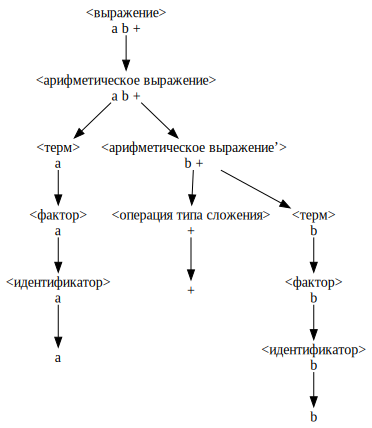

In [189]:
expr = (
        'a + b',
        'a b +',
    )

tree = parse(expr)
tree.children[0].print()

['a', '*', '(', 'b', '+', 'c', ')']
Выражение в обратной польской нотации:
a b c + *
OK


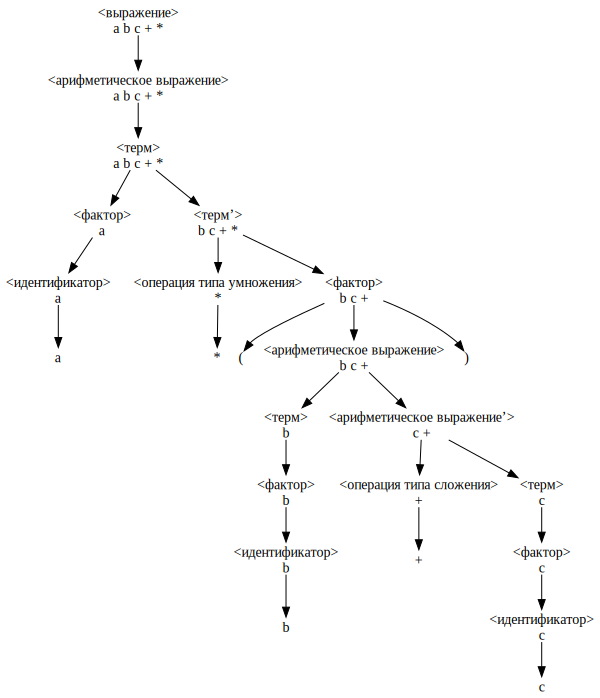

In [190]:
expr = (
        'a * (b + c)',
        'a b c + *',
    )

tree = parse(expr)
tree.children[0].print()

['a', '*', '(', 'b', '+', 'c', ')', '>=', '2.8', '*', 'd']
Выражение в обратной польской нотации:
a b c + * 2.8 d * >=
OK


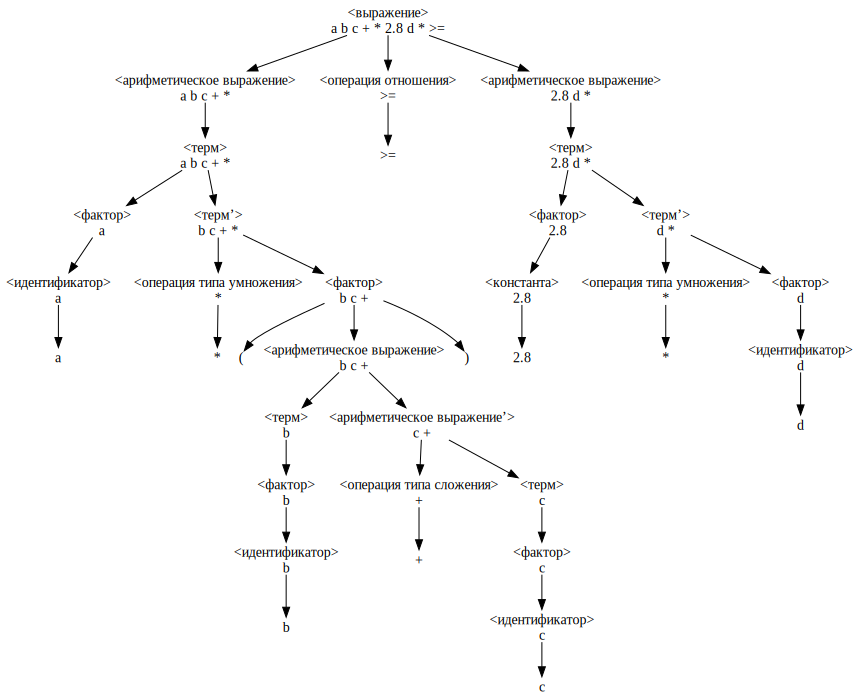

In [191]:
expr = (
        'a * (b + c) >= 2.8 * d',
        'a b c + * 2.8 d * >=',
    )

tree = parse(expr)
tree.children[0].print()

['a', '+', '(', 'a', '-', 'b', ')', '*', 'b', '*', 'c', '*', 'd', '<>', '0.3']
Выражение в обратной польской нотации:
a a b - b * c * d * + 0.3 <>
OK


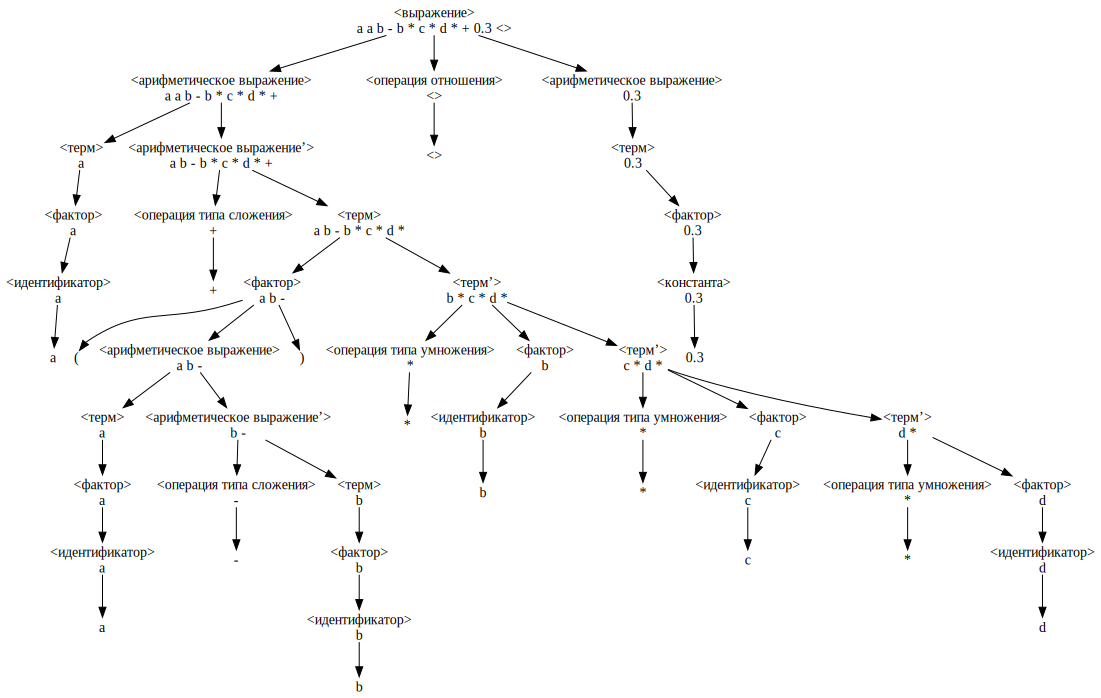

In [192]:
expr = (
        'a + (a - b)*b*c * d <> 0.3',
        'a a b - b * c * d * + 0.3 <>',
    )

tree = parse(expr)
tree.children[0].print()